# Train from data

This notebook walks you through training a normalizing flow by gradient descent when data is available.

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as data

import zuko

_ = torch.random.manual_seed(0)

## Dataset

We consider the *Two Moons* dataset for demonstrative purposes.

In [62]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(1000)

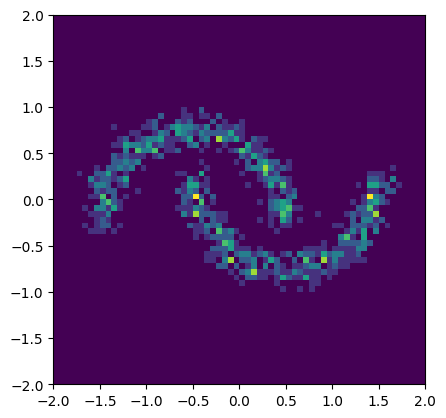

In [8]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [61]:
trainset = data.TensorDataset(*two_moons(1000))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

test_x, test_label = two_moons(1000)

## Unconditional flow

We use a neural spline flow (NSF) as density estimator $q_\phi(x)$. The goal of the unconditional flow is to approximate the entire Two Moons distribution.

In [ ]:
flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

The objective is to minimize the Kullback-Leibler (KL) divergence between the true data distribution $p(x)$ and the modeled distribution $q_\phi(x)$.

$$
    \begin{align}
        \arg \min_\phi & ~ \mathrm{KL} \big( p(x) || q_\phi(x) \big) \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \left[ \log \frac{p(x)}{q_\phi(x)} \right] \\
        = \arg \min_\phi & ~ \mathbb{E}_{p(x)} \big[ -\log q_\phi(x) \big]
    \end{align}
$$

In [13]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.356007695198059 ± 0.2076358050107956
(1) 1.241913080215454 ± 0.07183419913053513
(2) 1.2220325469970703 ± 0.07474563270807266
(3) 1.2202816009521484 ± 0.09026823192834854
(4) 1.2096105813980103 ± 0.07690950483083725
(5) 1.1767756938934326 ± 0.08725441992282867
(6) 1.1674695014953613 ± 0.07743680477142334
(7) 1.2414147853851318 ± 0.08253434300422668
(8) 1.1750972270965576 ± 0.09177818894386292
(9) 1.1809170246124268 ± 0.06898700445890427
(10) 1.178816318511963 ± 0.08382153511047363
(11) 1.1686012744903564 ± 0.08447514474391937
(12) 1.1933903694152832 ± 0.10624085366725922
(13) 1.2047760486602783 ± 0.1288013905286789
(14) 1.1435115337371826 ± 0.1078326478600502
(15) 1.1225653886795044 ± 0.07661737501621246
(16) 1.132516860961914 ± 0.07885310798883438
(17) 1.1573057174682617 ± 0.1971699744462967
(18) 1.1291602849960327 ± 0.08478101342916489
(19) 1.1551473140716553 ± 0.09174143522977829
(20) 1.1200048923492432 ± 0.06969847530126572
(21) 1.1001276969909668 ± 0.11178141832351685
(22) 1

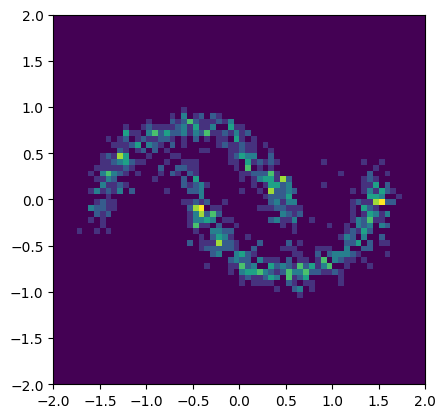

In [14]:
samples = flow().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [42]:
flow2 = zuko.flows.MAF(features=2, transforms=5, hidden_features=(64, 64))

optimizer = torch.optim.AdamW(flow2.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow2().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 2.0406432151794434 ± 0.2798718214035034
(1) 1.7968204021453857 ± 0.089007169008255
(2) 1.732995867729187 ± 0.06564917415380478
(3) 1.6991280317306519 ± 0.05460759997367859
(4) 1.6792315244674683 ± 0.07216064631938934
(5) 1.667980432510376 ± 0.06718031316995621
(6) 1.6331326961517334 ± 0.053530748933553696
(7) 1.6092058420181274 ± 0.04805658012628555
(8) 1.5697356462478638 ± 0.0767851397395134
(9) 1.5305814743041992 ± 0.060495104640722275
(10) 1.4943832159042358 ± 0.08657008409500122
(11) 1.4385236501693726 ± 0.07363668084144592
(12) 1.4324756860733032 ± 0.06222027167677879
(13) 1.4209896326065063 ± 0.07382329553365707
(14) 1.3917222023010254 ± 0.060986001044511795
(15) 1.3649674654006958 ± 0.07048661261796951
(16) 1.347280740737915 ± 0.09980129450559616
(17) 1.3367269039154053 ± 0.08426856994628906
(18) 1.3620421886444092 ± 0.09110281616449356
(19) 1.3142991065979004 ± 0.10420816391706467
(20) 1.2981387376785278 ± 0.08174256235361099
(21) 1.295025110244751 ± 0.044059161096811295
(2

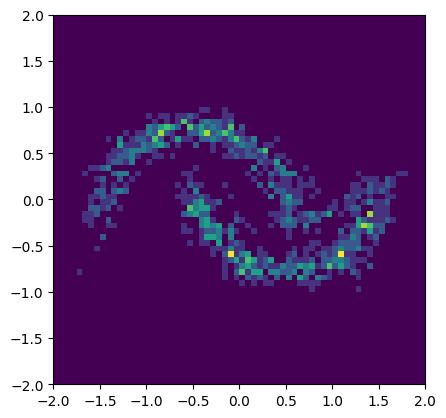

In [43]:
samples = flow2().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [34]:
flow3 = zuko.flows.NCSF(features=2, transforms=3)

optimizer = torch.optim.AdamW(flow3.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow3().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 2.9899752140045166 ± 0.36532238125801086
(1) 2.1527318954467773 ± 0.1704711765050888
(2) 1.776843547821045 ± 0.1139461100101471
(3) 1.545540690422058 ± 0.1194835752248764
(4) 1.404890537261963 ± 0.09833168983459473
(5) 1.3874400854110718 ± 0.10133039951324463
(6) 1.3142451047897339 ± 0.11579292267560959
(7) 1.2999897003173828 ± 0.10147761553525925
(8) 1.2689093351364136 ± 0.09280086308717728
(9) 1.2456978559494019 ± 0.06479006260633469
(10) 1.2439290285110474 ± 0.13691745698451996
(11) 1.233581304550171 ± 0.08310206979513168
(12) 1.2179555892944336 ± 0.1078379675745964
(13) 1.223143219947815 ± 0.12072950601577759
(14) 1.2000985145568848 ± 0.1049206480383873
(15) 1.1882208585739136 ± 0.06782229989767075
(16) 1.2362350225448608 ± 0.11517475545406342
(17) 1.1828320026397705 ± 0.11922412365674973
(18) 1.1755274534225464 ± 0.08866750448942184
(19) 1.16746187210083 ± 0.14113645255565643
(20) 1.1428437232971191 ± 0.10468016564846039
(21) 1.1750339269638062 ± 0.11691144853830338
(22) 1.161

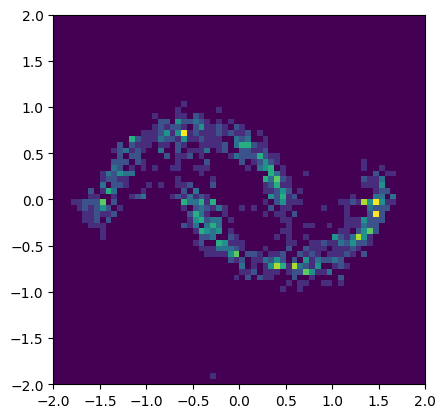

In [38]:
samples = flow3().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [49]:
flow4 = zuko.flows.BPF(features=2, degree=24)

optimizer = torch.optim.AdamW(flow4.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(100):
    losses = []

    for x, label in trainloader:
        loss = -flow4().log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 2.1713273525238037 ± 0.12690424919128418
(1) 1.9035700559616089 ± 0.07331062108278275
(2) 1.8480814695358276 ± 0.06827405840158463
(3) 1.8012781143188477 ± 0.04998960345983505
(4) 1.7691092491149902 ± 0.05711477994918823
(5) 1.7388739585876465 ± 0.0682976171374321
(6) 1.720192551612854 ± 0.05216490104794502
(7) 1.7007085084915161 ± 0.060160353779792786
(8) 1.679343581199646 ± 0.05622396618127823
(9) 1.6488394737243652 ± 0.06840790808200836
(10) 1.6005855798721313 ± 0.07271748036146164
(11) 1.565701961517334 ± 0.06558974832296371
(12) 1.4962972402572632 ± 0.05798187479376793
(13) 1.4432098865509033 ± 0.05689460039138794
(14) 1.4120129346847534 ± 0.0728025957942009
(15) 1.3913402557373047 ± 0.056076936423778534
(16) 1.3923993110656738 ± 0.10363446921110153
(17) 1.3498209714889526 ± 0.07103634625673294
(18) 1.3447051048278809 ± 0.08929471671581268
(19) 1.334661841392517 ± 0.06806662678718567
(20) 1.3401641845703125 ± 0.10755983740091324
(21) 1.3431622982025146 ± 0.07288950681686401
(2

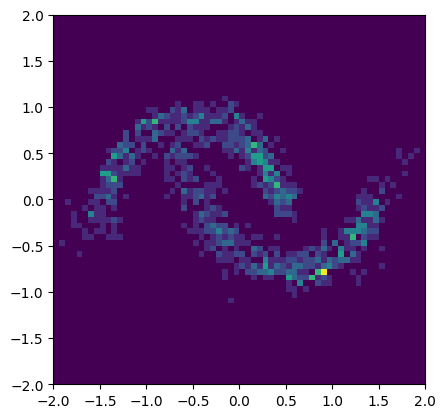

In [51]:
samples = flow4().sample((1000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [50]:
from math import prod

count = 0
for param in flow.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow2.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow3.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in flow4.parameters():
    count += prod(list(param.shape))

print(count)

22026
23060
22026
22806


## Conditional flow

We use a conditional NSF as density estimator $q_\phi(x | c)$, where $c$ is the label indicating either the top or bottom moon of the Two Moons distribution.

In [107]:
cflow = zuko.flows.NSF(features=2, context=1, transforms=1, hidden_features=(64, 64))
cflow2 = zuko.flows.MAF(features=2, context=1, transforms=2, hidden_features=(64, 64))
cflow3 = zuko.flows.NCSF(features=2, context=1, transforms=1)
cflow4 = zuko.flows.BPF(features=2, context=1, degree=2)

from math import prod

count = 0
for param in cflow.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow2.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow3.parameters():
    count += prod(list(param.shape))

print(count)

count = 0
for param in cflow4.parameters():
    count += prod(list(param.shape))

print(count)


7406
9352
7406
14418


In [110]:
n = 512
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=n, shuffle=True)

for i, cf in enumerate([cflow, cflow2, cflow3, cflow4]):
    optimizer = torch.optim.AdamW(cf.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(100):
        losses = []

        for x, label in trainloader:
            c = label.unsqueeze(dim=-1)

            loss = -cf(c).log_prob(x).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

    print(f"cflow({i})", losses.mean().item(), "±", losses.std().item())

/tmp/ipykernel_15311/1863996181.py:24: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  print(f"cflow({i})", losses.mean().item(), "±", losses.std().item())


cflow(0) 0.4199759364128113 ± nan
cflow(1) 0.618799090385437 ± nan
cflow(2) 0.7489145994186401 ± nan
cflow(3) 1.590122103691101 ± nan


NSF ACC: tensor(0.9960)
MAF ACC: tensor(0.9940)
NCSF ACC: tensor(0.9730)
BPF ACC: tensor(0.9210)


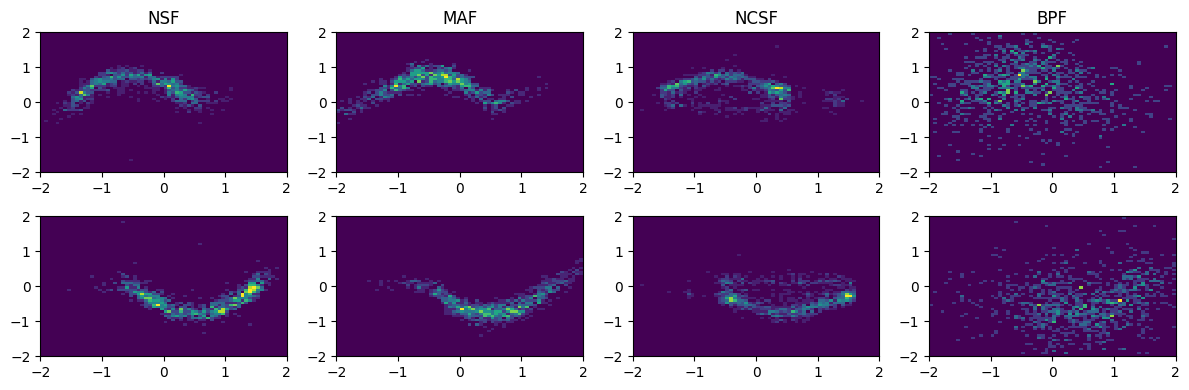

In [111]:
# sample from the flow conditioned on the top moon label
fig, axes = plt.subplots(2, 4, figsize=(12, 4))

for i, name, cf in zip(range(4), ['NSF', 'MAF', 'NCSF', 'BPF'], [cflow, cflow2, cflow3, cflow4]):
    samples1 = cf(torch.tensor([0.0])).sample((1000,))
    samples2 = cf(torch.tensor([1.0])).sample((1000,))

    log_probs = torch.stack(
        [
            cf(torch.tensor([0.0])).log_prob(test_x),
            cf(torch.tensor([1.0])).log_prob(test_x)
        ],
        -1)

    print(name, 'ACC:', torch.mean( (log_probs.argmax(-1) == test_label).type(torch.float) ))

    axes[0, i].hist2d(*samples1.T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

fig.tight_layout()

## Mixture of normalizing flows

The objective is to minimize the evidence lower bound (ELBO) of the following generative model:
$$ p(x|c) p(c) $$

We will test two cases:
- One where we directly minimize the marginal log-likelihood defined as  

$$ - \ln q_\phi(x) = - \ln [\sum_c q_\phi(x|c) p(c)]$$

and another where we used ammortized posterior $q_\rho(c|x)$ and minimize the 
corresponding ELBO 

$$
    \arg \min_{\phi, \rho} ~ \mathrm{KL} \big( q_\rho(c|x) || q_\phi(x|c) p(c) \big)
$$

In [197]:
from torchvision.ops import MLP

class ELBO(torch.nn.Module):
    def __init__(
        self,
        decoder: zuko.lazy.LazyDistribution,
        prior: zuko.lazy.LazyDistribution,
    ):
        super().__init__()

        self.decoder = decoder
        self.prior = prior

    def log_joint(self, x: torch.Tensor) -> torch.Tensor:
        n_components = self.prior._num_events
        log_probs = []
        for c in torch.arange(n_components, dtype=torch.float).to(device=x.device):
            log_probs.append(self.decoder(c.unsqueeze(dim=-1)).log_prob(x))

        return torch.stack(log_probs, dim=-1) + self.prior.logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return - torch.logsumexp(self.log_joint(x), -1)
    
    def posterior(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.Softmax(dim=-1)(self.log_joint(x))

    
class ELBOAmort(torch.nn.Module):
    def __init__(
        self,
        encoder: MLP,
        decoder: zuko.lazy.LazyDistribution,
        prior: zuko.lazy.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ln_q = self.encoder(x)
        n_components = ln_q.shape[-1]
        log_probs = []
        for c in torch.arange(n_components, dtype=torch.float).to(device=x.device):
            log_probs.append(self.decoder(c.unsqueeze(dim=-1)).log_prob(x))
        
        q = torch.nn.Softmax(dim=-1)(ln_q)
        log_q_m_log_p = - torch.stack(log_probs, -1) - self.prior.logits + ln_q - torch.logsumexp(ln_q, dim=-1, keepdim=True)
        return torch.sum(log_q_m_log_p * q, -1)
    
cuda0 = torch.device('cuda:0')

NSF 1.0239191055297852 ± 0.07457853853702545
NSF classification ACC: tensor(0.8790)
MAF 1.1063883304595947 ± 0.06747893989086151
MAF classification ACC: tensor(0.9600)
NCSF 1.132355809211731 ± 0.07554811984300613
NCSF classification ACC: tensor(0.6310)
BPF 1.0538289546966553 ± 0.06143559515476227
BPF classification ACC: tensor(0.8060)


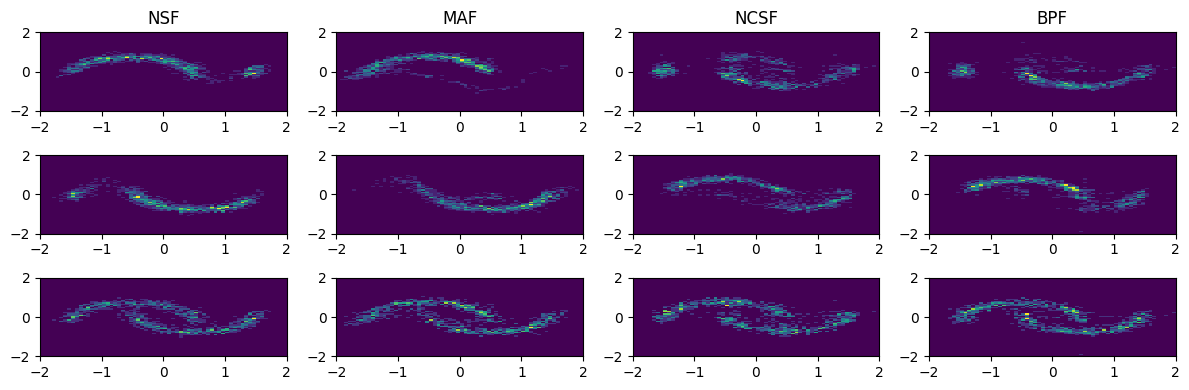

In [195]:
n = 4_000
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=128, shuffle=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 4))

names = ['NSF', 'MAF', 'NCSF', 'BPF']

cflow = zuko.flows.NSF(features=2, context=1, transforms=1, hidden_features=(64, 64))
cflow2 = zuko.flows.MAF(features=2, context=1, transforms=2, hidden_features=(64, 64))
cflow3 = zuko.flows.NCSF(features=2, context=1, transforms=1)
cflow4 = zuko.flows.BPF(features=2, context=1, degree=2)

decoders = [cflow, cflow2, cflow3, cflow3]

for i, name, decoder in zip(range(len(names)), names, decoders):
    cat = zuko.distributions.Categorical(logits=torch.zeros(2).to(cuda0))
    elbo = ELBO(decoder, cat).to(device=cuda0)
    optimizer = torch.optim.AdamW(elbo.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(200):
        losses = []

        for x, label in trainloader:
            loss = elbo(x.to(device=cuda0)).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

    print(f"{name}", losses.mean().item(), "±", losses.std().item())
    
    with torch.no_grad():
        samples1 = elbo.decoder(torch.tensor([0.0]).to(cuda0)).sample((1000,))
        samples2 = elbo.decoder(torch.tensor([1.0]).to(cuda0)).sample((1000,))
        cats = elbo.prior.sample((1000,)).to(cuda0)

        samples = torch.where((cats == 1).unsqueeze(dim=-1), samples2, samples1)
        q = elbo.posterior(test_x.to(cuda0))

        acc = torch.mean((q.argmax(-1).cpu() == test_label).type(torch.float))
        print(f"{name} classification ACC:", torch.max(acc, 1 - acc))  # we do not know which component is which label, so just print larger value.



    axes[0, i].hist2d(*samples1.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[2, i].hist2d(*samples.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

fig.tight_layout()
    

### Variant with amortized categorical posterior

NSF 1.026357650756836 ± 0.06484553962945938
NSF classification ACC: tensor(0.8210)
MAF 1.024796962738037 ± 0.06309052556753159
MAF classification ACC: tensor(0.9990)
NCSF 1.0980881452560425 ± 0.07580306380987167
NCSF classification ACC: tensor(0.8290)
BPF 1.0477768182754517 ± 0.08363337814807892
BPF classification ACC: tensor(0.8080)


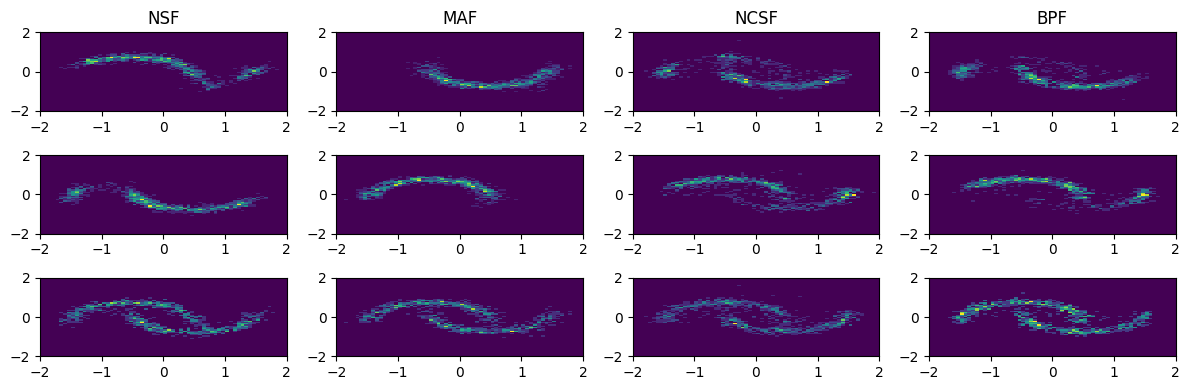

In [199]:
n_components = 2
n = 4_000
trainset = data.TensorDataset(*two_moons(n))
trainloader = data.DataLoader(trainset, batch_size=128, shuffle=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 4))
names = ['NSF', 'MAF', 'NCSF', 'BPF']

cflow = zuko.flows.NSF(features=2, context=1, transforms=1, hidden_features=(64, 64))
cflow2 = zuko.flows.MAF(features=2, context=1, transforms=2, hidden_features=(64, 64))
cflow3 = zuko.flows.NCSF(features=2, context=1, transforms=1)
cflow4 = zuko.flows.BPF(features=2, context=1, degree=2)

decoders = [cflow, cflow2, cflow3, cflow3]

for i, name, decoder in zip(range(len(names)), names, decoders):
    cat_net = MLP(in_channels=2, hidden_channels=[64, n_components]).to(cuda0)
    cat = zuko.distributions.Categorical(logits=torch.zeros(n_components).to(cuda0))
    elbo = ELBOAmort(cat_net, decoder.to(cuda0), cat).to(cuda0)
    optimizer = torch.optim.AdamW(elbo.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(200):
        losses = []

        for x, label in trainloader:
            loss = elbo(x.to(cuda0)).mean()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

    print(f"{name}", losses.mean().item(), "±", losses.std().item())

    with torch.no_grad():
        samples1 = elbo.decoder(torch.tensor([0.0]).to(cuda0)).sample((1000,))
        samples2 = elbo.decoder(torch.tensor([1.0]).to(cuda0)).sample((1000,))
        cats = elbo.prior.sample((1000,)).to(cuda0)

        samples = torch.where((cats == 1).unsqueeze(dim=-1), samples2, samples1)
        ln_q = elbo.encoder(test_x.to(cuda0))

        acc = torch.mean((ln_q.argmax(-1).cpu() == test_label).type(torch.float))
        print(f"{name} classification ACC:", torch.max(acc, 1 - acc))

    axes[0, i].hist2d(*samples1.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[1, i].hist2d(*samples2.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[2, i].hist2d(*samples.cpu().T, bins=64, range=((-2, 2), (-2, 2)))
    axes[0, i].set_title(name)

fig.tight_layout()